In [ ]:
# Importation des package
#!pip install arch
#!pip install yfinance

In [506]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import pandas as pd
import arch
from arch import arch_model
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import itertools
from scipy.stats import shapiro, jarque_bera
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
from scipy.stats import jarque_bera, norm, probplot, skew, kurtosis
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.optimize import minimize

## Télécharger les données

In [6]:
index_cw8 = 'CW8.PA' # Indices de Amundi MSCI World UCITS ETF - EUR (C)
index_ci2 = 'CI2.PA' # Amundi MSCI India UCITS ETF - EUR (C)
index_epre = 'EPRE.PA' # Amundi FTSE EPRA Europe Real Estate UCITS ETF-C
start_date = '2018-01-31' # Date de debut
end_date = '2025-04-01' 
data_cw8 = yf.download(index_cw8, start=start_date, end=end_date, progress=False)
data_ci2 = yf.download(index_ci2, start=start_date, end=end_date, progress=False)
data_epre = yf.download(index_epre, start=start_date, end=end_date, progress=False)

In [87]:
data_msci_world = data_cw8[('Close', 'CW8.PA')].copy()
data_msci_india = data_ci2[('Close', 'CI2.PA')].copy()
data_real_estate = data_epre[('Close', 'EPRE.PA')].copy()

In [89]:
data_msci_world = data_msci_world.to_frame(name='CW8')
data_msci_world.reset_index(inplace=True)

data_msci_india = data_msci_india.to_frame(name='CI2')
data_msci_india.reset_index(inplace=True)

data_real_estate = data_real_estate.to_frame(name='EPRE')
data_real_estate.reset_index(inplace=True)


In [91]:
#Vérification de la dimension
print(data_msci_world.shape)
print(data_msci_india.shape)
print(data_real_estate.shape)

(1836, 2)
(1836, 2)
(1836, 2)


In [93]:
#Vérification des valeurs manquantes
print(data_msci_world.isna().sum())
print(data_msci_india.isna().sum())
print(data_real_estate.isna().sum())

Date    0
CW8     0
dtype: int64
Date    0
CI2     0
dtype: int64
Date    0
EPRE    0
dtype: int64


In [95]:
data_msci_world.head()

,Date,CW8
0,2018-01-31,253.532104
1,2018-02-01,253.225204
2,2018-02-02,249.209305
3,2018-02-05,241.745193
4,2018-02-06,242.681595


In [97]:
data_msci_india.head()

,Date,CI2
0,2018-01-31,519.106689
1,2018-02-01,515.603577
2,2018-02-02,502.494904
3,2018-02-05,499.544800
4,2018-02-06,492.758911


In [99]:
data_real_estate.head()

,Date,EPRE
0,2018-01-31,355.311493
1,2018-02-01,351.950287
2,2018-02-02,346.420013
3,2018-02-05,339.282196
4,2018-02-06,331.681488


## Fusion des bases de données

In [101]:
# Fusionner les trois DataFrames sur la colonne "Date"
data_merged = data_msci_world.merge(data_msci_india, on='Date', how='outer').merge(data_real_estate, on='Date', how='outer')

In [103]:
data_merged

,Date,CW8,CI2,EPRE
0,2018-01-31,253.532104,519.106689,355.311493
1,2018-02-01,253.225204,515.603577,351.950287
2,2018-02-02,249.209305,502.494904,346.420013
3,2018-02-05,241.745193,499.544800,339.282196
4,2018-02-06,242.681595,492.758911,331.681488
...,...,...,...,...
1831,2025-03-25,551.275330,914.711304,303.895599
1832,2025-03-26,548.686401,906.323608,304.279999
1833,2025-03-27,546.597229,911.984375,305.077087
1834,2025-03-28,534.836670,900.911316,309.802795


In [105]:
#Vérification des valeurs manquantes
print(data_merged.isna().sum())

Date    0
CW8     0
CI2     0
EPRE    0
dtype: int64


In [107]:
data_merged.to_csv("data_etf.csv", index=False)

## Exercice 1

In [109]:
data_etf1 = pd.read_csv('data_etf.csv')

In [111]:
# Chargement des données
data_etf = pd.read_csv('data_etf.csv', parse_dates=['Date'], index_col='Date')

In [113]:
data_etf['CW8'].head()

Date
2018-01-31    253.532104
2018-02-01    253.225204
2018-02-02    249.209305
2018-02-05    241.745193
2018-02-06    242.681595
Name: CW8, dtype: float64

In [115]:
data_etf.head()

,CW8,CI2,EPRE
Date,,,
2018-01-31,253.532104,519.106689,355.311493
2018-02-01,253.225204,515.603577,351.950287
2018-02-02,249.209305,502.494904,346.420013
2018-02-05,241.745193,499.544800,339.282196
2018-02-06,242.681595,492.758911,331.681488


In [117]:
data_etf.iloc[0]

CW8     253.532104
CI2     519.106689
EPRE    355.311493
Name: 2018-01-31 00:00:00, dtype: float64

In [125]:
# Normalisation à 100 à la première date
data_etf_norm = data_etf.div(data_etf.iloc[0]).mul(100)

In [127]:
data_etf_norm.head()

,CW8,CI2,EPRE
Date,,,
2018-01-31,100.000000,100.000000,100.000000
2018-02-01,99.878950,99.325165,99.054011
2018-02-02,98.294970,96.799928,97.497554
2018-02-05,95.350920,96.231624,95.488664
2018-02-06,95.720262,94.924400,93.349496


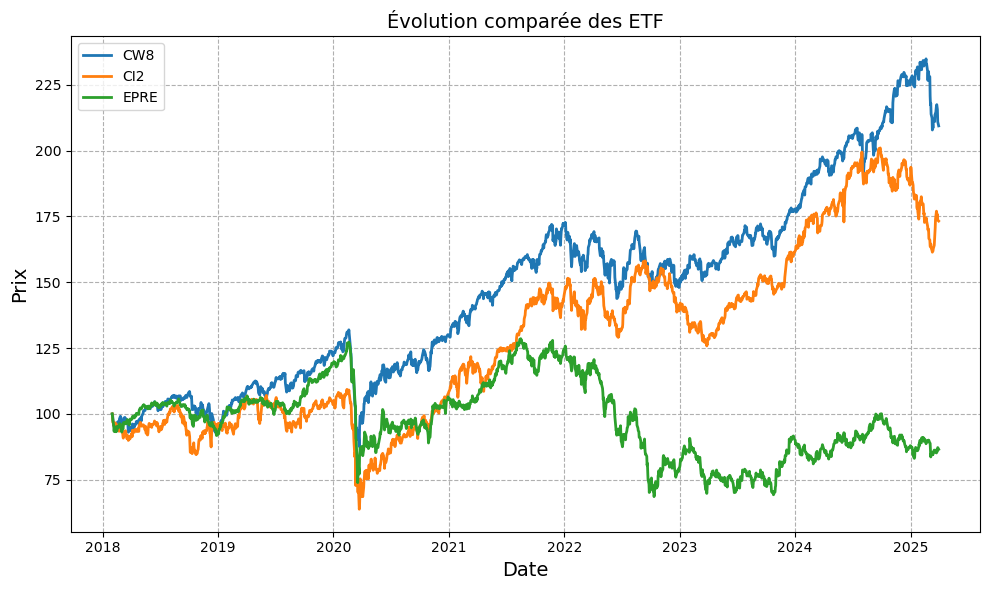

In [250]:
# Tracé
plt.figure(figsize=(10, 6))
for col in data_etf_norm.columns:
    plt.plot(data_etf_norm.index, data_etf_norm[col], label=col, linewidth=2)

plt.title("Évolution comparée des ETF", fontsize = 14)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("Prix", fontsize = 14)
plt.legend()
plt.grid(True, linestyle = '--')
plt.tight_layout()

# sauver le graphique
plt.savefig(
    'graph_etf.png',
    format='png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()



## Exercice 2

### Rendement géometrique

In [540]:
# Calcul des log‐returns (%) : r_t = 100 * log(P_t / P_{t-1})
log_ret = 100 * np.log(data_etf_norm / data_etf_norm.shift(1))

# Suppression de la première ligne (NaN)
log_ret = log_ret.dropna()

# Affichage
print("Rendements géométriques (log‐returns ×100) :")
print(log_ret.head())

# Sauvegarde dans un fichier CSV
log_ret.to_csv("etf_log_returns.csv", index=True)

print("✅ Données sauvegardées dans 'etf_log_returns.csv'")

Rendements géométriques (log‐returns ×100) :
                 CW8       CI2      EPRE
Date                                    
2018-02-01 -0.121123 -0.677122 -0.950491
2018-02-02 -1.598610 -2.575271 -1.583798
2018-02-05 -3.040887 -0.588821 -2.081975
2018-02-06  0.386602 -1.367725 -2.265706
2018-02-07  0.521300  0.227941  1.996067
✅ Données sauvegardées dans 'etf_log_returns.csv'


### Test de stationnarité - Test augmenté de Dickey-Fuller (ADF)

In [260]:
# Test de stationnarité - Test augmenté de Dickey-Fuller (ADF)
etfs = ['CW8', 'CI2', 'EPRE']

for etf in etfs:
    print(f"\nTest ADF pour {etf}:")
    result = adfuller(log_ret[etf])
    print('  Statistique du test ADF:', result[0])
    print('  Valeur critique 1%:', result[4]['1%'])
    print('  Valeur critique 5%:', result[4]['5%'])
    print('  Valeur critique 10%:', result[4]['10%'])
    print('  P-value:', result[1])
    print('  Est stationnaire ?', 'Oui' if result[1] < 0.05 else 'Non')


Test ADF pour CW8:
  Statistique du test ADF: -13.284955500123584
  Valeur critique 1%: -3.433936263195097
  Valeur critique 5%: -2.8631241351249
  Valeur critique 10%: -2.5676133397235263
  P-value: 7.560810167566686e-25
  Est stationnaire ? Oui

Test ADF pour CI2:
  Statistique du test ADF: -9.660804594034921
  Valeur critique 1%: -3.4339481027788024
  Valeur critique 5%: -2.8631293617920544
  Valeur critique 10%: -2.5676161227508754
  P-value: 1.3551792752158852e-16
  Est stationnaire ? Oui

Test ADF pour EPRE:
  Statistique du test ADF: -15.701805367710028
  Valeur critique 1%: -3.4339323339630248
  Valeur critique 5%: -2.863122400533316
  Valeur critique 10%: -2.5676124161116403
  P-value: 1.3931816646896423e-28
  Est stationnaire ? Oui


## Statistiques descriptives

In [166]:
# Statistiques descriptives

def full_stats(s):
    stats_dict = {}
    stats_dict['Moyenne (%)'] = s.mean()
    stats_dict['Médiane (%)'] = s.median()
    stats_dict['Minimum (%)'] = s.min()
    stats_dict['Percentile 5%'] = s.quantile(0.25)
    stats_dict['Percentile 95%'] = s.quantile(0.75)
    stats_dict['Maximum (%)'] = s.max()
    stats_dict['Écart-type (%)'] = s.std()
    stats_dict['Asymétrie'] = s.skew()
    stats_dict['Excès de kurtosis'] = s.kurtosis()
    return pd.Series(stats_dict)

# Application à chaque ETF
desc_stats = log_ret.apply(full_stats)


# Création d'un tableau LaTeX pour le rapport
latex_table = desc_stats.round(4).to_latex(escape=False)

# Affichage
print("Statistiques descriptives des rendements (log-returns en %) :")
print(desc_stats)

# Sauvegarde du tableau LaTeX
with open('statistiques_etf1.tex', 'w', encoding='utf-8') as f:
    f.write(latex_table)

Statistiques descriptives des rendements (log-returns en %) :
                        CW8        CI2       EPRE
Moyenne (%)        0.040269   0.029942  -0.007885
Médiane (%)        0.099128   0.104069   0.010396
Minimum (%)       -8.626727 -16.358204 -12.822657
Percentile 5%     -0.380905  -0.568219  -0.688674
Percentile 95%     0.540018   0.668494   0.707395
Maximum (%)        7.901232  13.290198   8.719697
Écart-type (%)     0.992055   1.360866   1.338874
Asymétrie         -0.842223  -1.402051  -0.420520
Excès de kurtosis  8.690512  25.033478   8.491164


### La matrice des corrélations entre les rendements des 3 ETF

In [180]:
corr = log_ret.corr()
corr


,CW8,CI2,EPRE
CW8,1.000000,0.595657,0.575898
CI2,0.595657,1.000000,0.399635
EPRE,0.575898,0.399635,1.000000


In [185]:
log_ret['CW8']

Date
2018-02-01   -0.121123
2018-02-02   -1.598610
2018-02-05   -3.040887
2018-02-06    0.386602
2018-02-07    0.521300
                ...   
2025-03-25    0.131551
2025-03-26   -0.470731
2025-03-27   -0.381486
2025-03-28   -2.175079
2025-03-31   -0.753669
Name: CW8, Length: 1835, dtype: float64

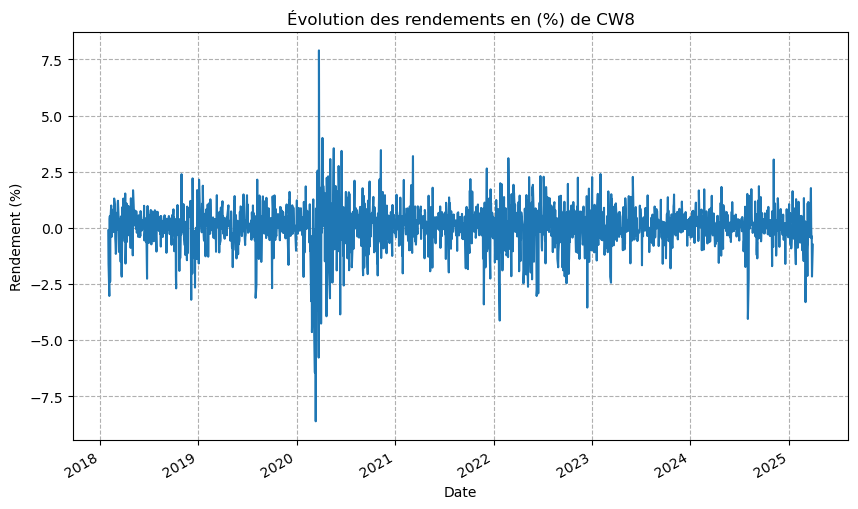

In [252]:
# évolution des rendements de CW8
log_ret['CW8'].plot(figsize=(10,6))
plt.title("Évolution des rendements en (%) de CW8")
plt.ylabel("Rendement (%)")
plt.grid(True, linestyle = '--')

# sauver le graphique
#plt.savefig(
 #   'rend_CW8.png',
#    format='png',
#    dpi=300,
#    bbox_inches='tight'
#)

plt.show()

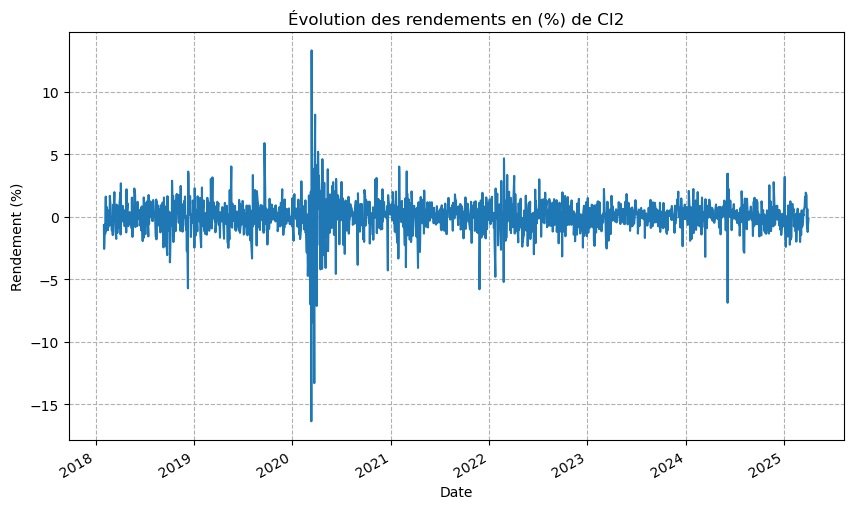

In [254]:
# évolution des rendements de CI2
log_ret['CI2'].plot(figsize=(10,6))
plt.title("Évolution des rendements en (%) de CI2")
plt.ylabel("Rendement (%)")
plt.grid(True, linestyle = '--')

# sauver le graphique
#plt.savefig(
#    'rend_CI2.png',
#    format='png',
 #   dpi=300,
 #   bbox_inches='tight'
#)

plt.show()

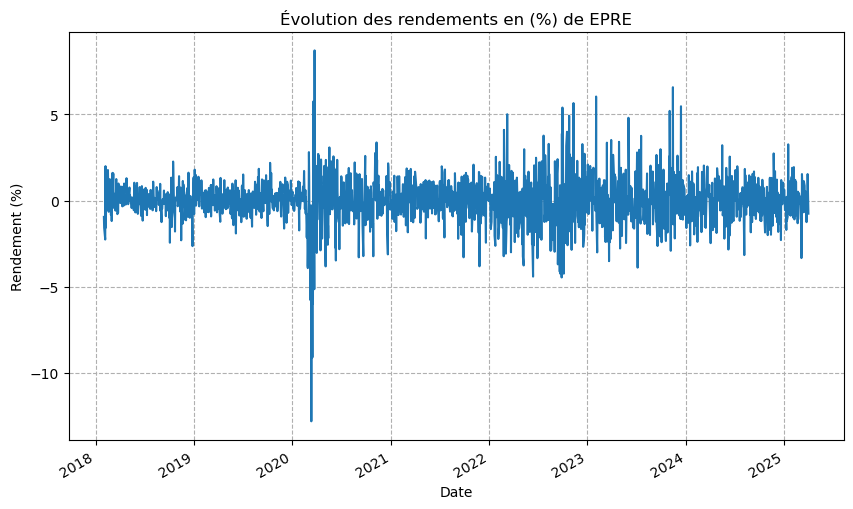

In [256]:
# évolution des rendements de EPRE
log_ret['EPRE'].plot(figsize=(10,6))
plt.title("Évolution des rendements en (%) de EPRE")
plt.ylabel("Rendement (%)")
plt.grid(True, linestyle = '--')

# sauver le graphique
#plt.savefig(
#    'rend_EPRE.png',
 #   format='png',
  #  dpi=300,
   # bbox_inches='tight'
#)

plt.show()

In [239]:
# Fonction d'autocorrélation
n_lags = 40
acf_df = pd.DataFrame()

for col in log_ret.columns:
    acf_values = acf(log_ret[col], nlags=n_lags, fft=False)
    acf_df[col] = acf_values

acf_df.index.name = 'Lag'
print(acf_df)

# Création d'un tableau LaTeX pour le rapport
acf_df_table = acf_df.round(4).to_latex(escape=False)

# Sauvegarde du tableau LaTeX
with open('acf_df.tex', 'w', encoding='utf-8') as f:
    f.write(acf_df_table)

          CW8       CI2      EPRE
Lag                              
0    1.000000  1.000000  1.000000
1   -0.011443 -0.173386  0.019615
2    0.012605  0.038935  0.054025
3    0.008500  0.024688  0.027703
4   -0.001317  0.018870  0.023764
5    0.038762  0.065942 -0.000415
6   -0.067399 -0.144428 -0.071061
7    0.074729  0.096543  0.052256
8   -0.017467  0.003396 -0.003169
9    0.044537  0.055173 -0.017963
10   0.025059 -0.023978  0.001618
11   0.001688  0.047968  0.056255
12   0.024212  0.039892  0.048564
13  -0.065808 -0.088344  0.011035
14   0.015313  0.024662 -0.005357
15   0.004508  0.060939 -0.021448
16  -0.005056 -0.034883 -0.014543
17  -0.023510  0.007986 -0.036351
18  -0.050304 -0.000987 -0.040198
19   0.031615  0.017726  0.007305
20  -0.017394  0.002749  0.000713
21  -0.022613 -0.023437 -0.039091
22  -0.016151  0.049221 -0.006322
23  -0.054127 -0.033201 -0.047958
24  -0.027864 -0.029006  0.002786
25  -0.004255 -0.007186  0.009831
26  -0.000713 -0.004277 -0.013458
27   0.000573 

### Afficher les fonctions d'autocorrélation pour chaque ETF

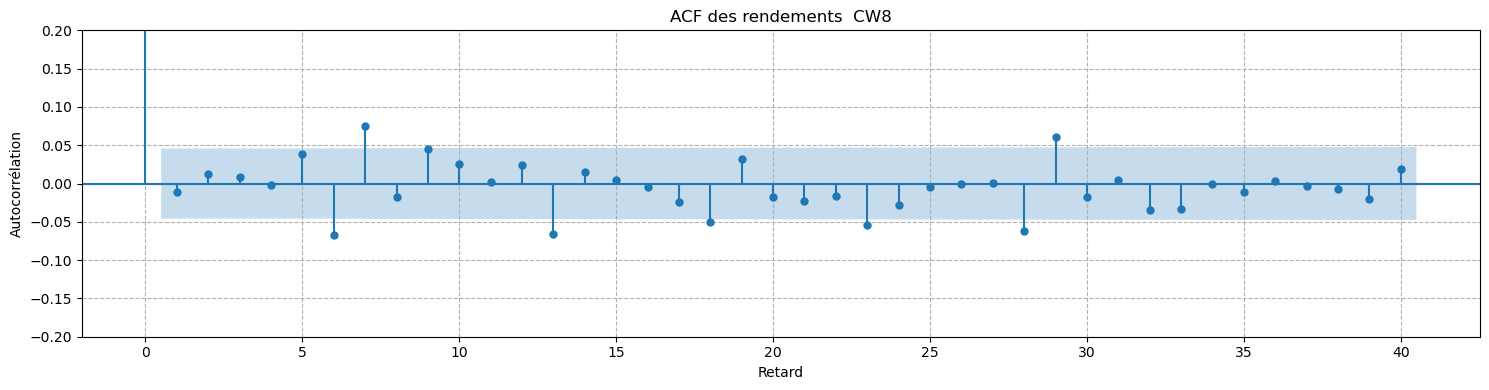

In [276]:
# CW8
plt.figure(figsize=(15, 4))
plot_acf(log_ret['CW8'], lags=40, ax=plt.gca(), title='ACF des rendements  CW8')
plt.xlabel("Retard")
plt.ylabel("Autocorrélation")
plt.ylim(-0.2, 0.2)
plt.grid(True, linestyle = '--')
plt.tight_layout()

# sauver le graphique
#plt.savefig(
#    'acf_CW8.png',
#    format='png',
#    dpi=300,
 #   bbox_inches='tight'
#)

plt.show()

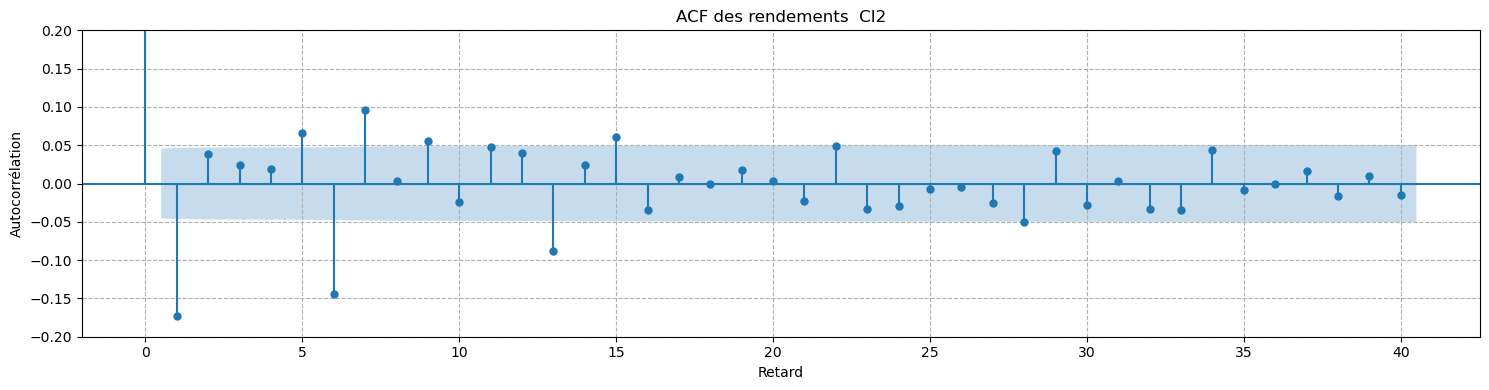

In [278]:
# CI2
plt.figure(figsize=(15, 4))
plot_acf(log_ret['CI2'], lags=40, ax=plt.gca(), title='ACF des rendements  CI2')
plt.xlabel("Retard")
plt.ylabel("Autocorrélation")
plt.ylim(-0.2, 0.2)
plt.grid(True, linestyle = '--')
plt.tight_layout()

# sauver le graphique
#plt.savefig(
#    'acf_CI2.png',
#    format='png',
#    dpi=300,
#    bbox_inches='tight'
#)
plt.show()

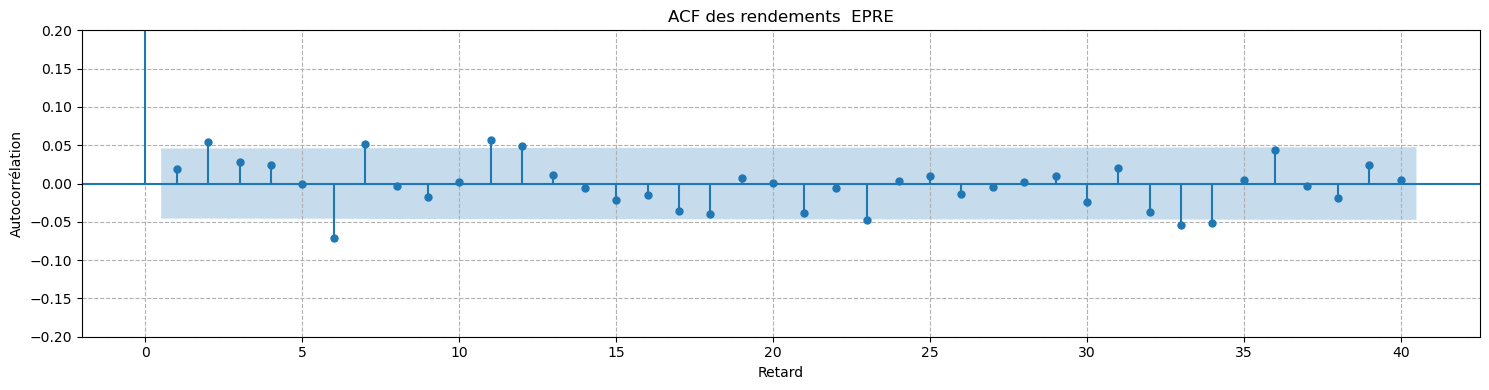

In [280]:
# EPRE
plt.figure(figsize=(15, 4))
plot_acf(log_ret['EPRE'], lags=40, ax=plt.gca(), title='ACF des rendements  EPRE')
plt.xlabel("Retard")
plt.ylabel("Autocorrélation")
plt.ylim(-0.2, 0.2)
plt.grid(True, linestyle = '--')
plt.tight_layout()

# sauver le graphique
#plt.savefig(
#    'acf_EPRE.png',
#    format='png',
#    dpi=300,
#    bbox_inches='tight'
#)
plt.show()

### Évolution du carré des rendements

In [282]:
log_ret.head()

,CW8,CI2,EPRE
Date,,,
2018-02-01,-0.121123,-0.677122,-0.950491
2018-02-02,-1.598610,-2.575271,-1.583798
2018-02-05,-3.040887,-0.588821,-2.081975
2018-02-06,0.386602,-1.367725,-2.265706
2018-02-07,0.521300,0.227941,1.996067


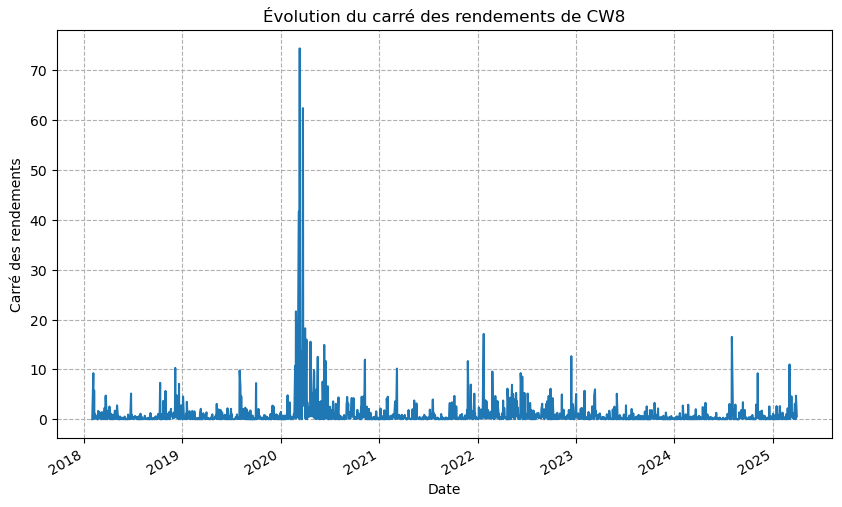

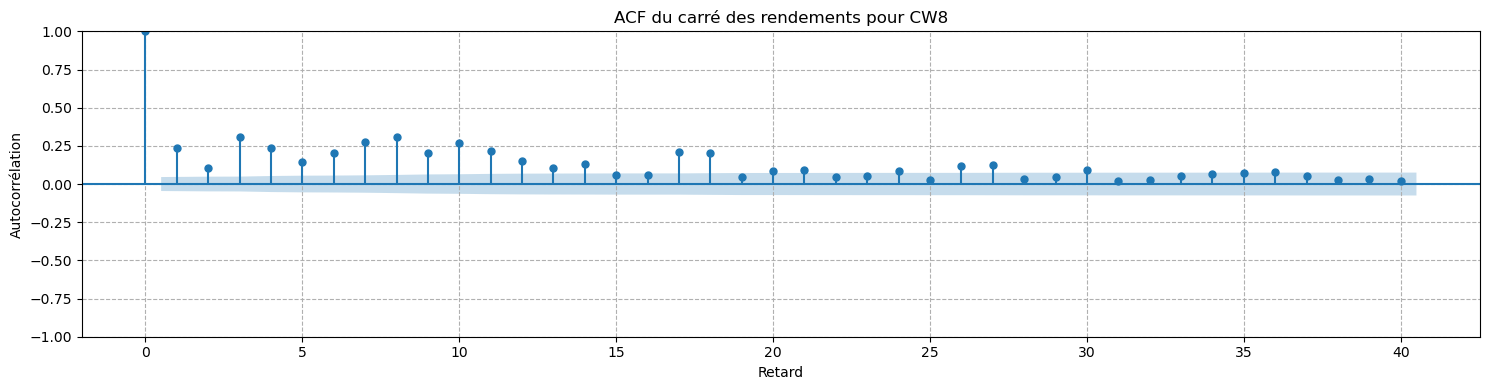

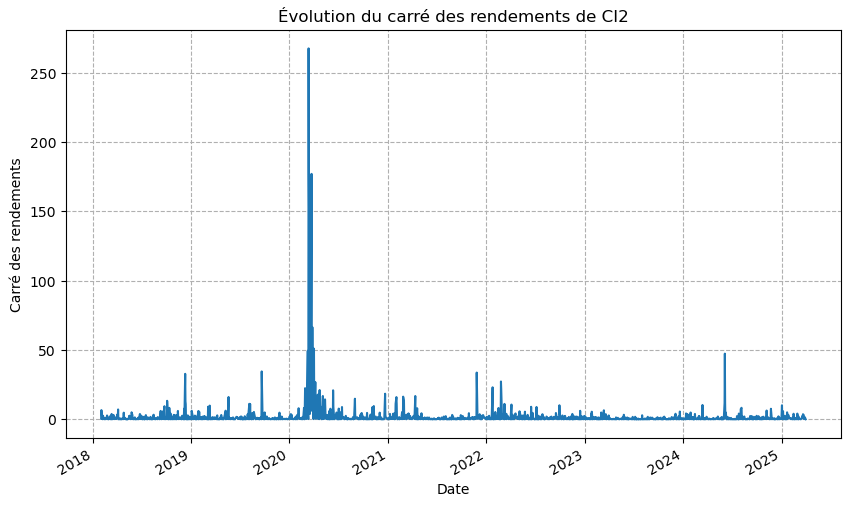

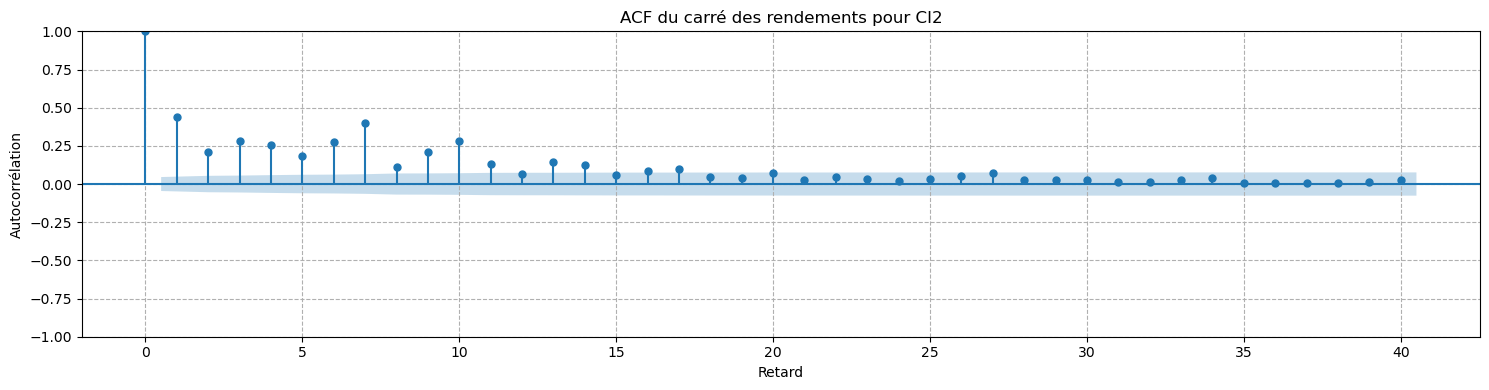

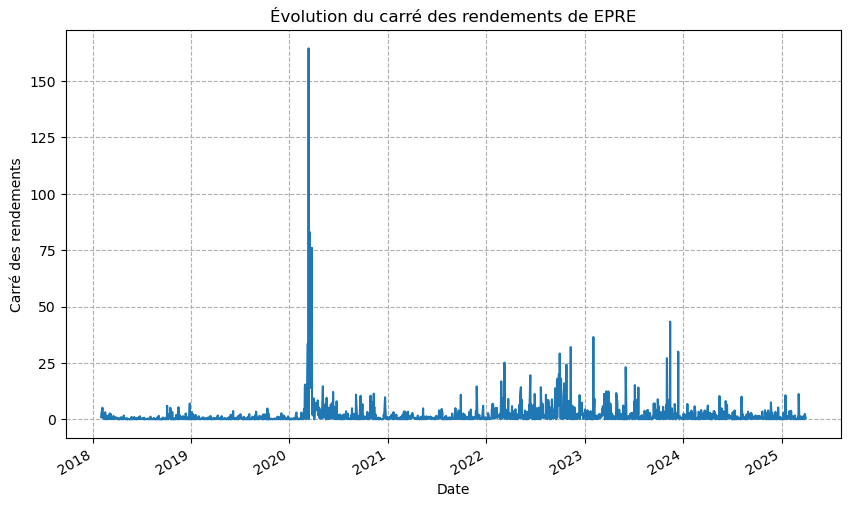

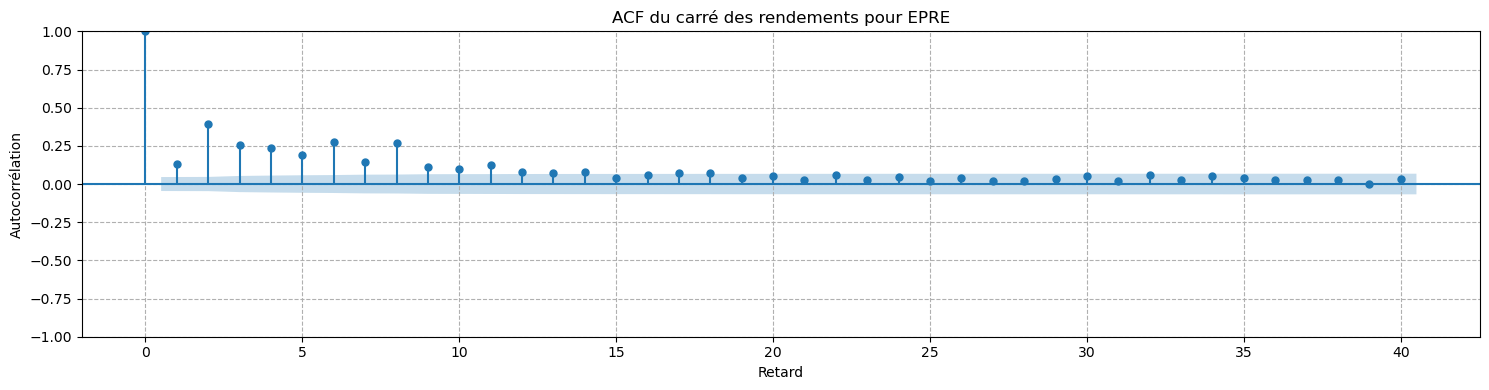

In [297]:
etfs = ['CW8', 'CI2', 'EPRE']

for etf in etfs:
    # Calcul du carré des rendements
    squared_log_ret = log_ret[etf] ** 2

    squared_log_ret.plot(figsize=(10,6))
    plt.title(f"Évolution du carré des rendements de {etf}")
    plt.ylabel("Carré des rendements")
    plt.grid(True, linestyle = '--')

    # sauver le graphique
    #plt.savefig(
    #    f'squared_rend_{etf}.png',
     #   format='png',
     #   dpi=300,
      #  bbox_inches='tight'
   # )

    plt.show()

    # Affichage de la fonction d'autocorrélation (ACF)
    plt.figure(figsize=(15, 4))
    plot_acf(squared_log_ret.dropna(), lags=40, ax=plt.gca())
    plt.title(f"ACF du carré des rendements pour {etf}")
    plt.xlabel("Retard")
    plt.ylabel("Autocorrélation")
    plt.grid(True, linestyle = '--')
    plt.tight_layout()
    # sauver le graphique
   # plt.savefig(
    #    f'squared_acf_{etf}.png',
     #   format='png',
      #  dpi=300,
      #  bbox_inches='tight'
    #)
    plt.show()

## Exercice 3

### Modèle GARCH


Estimation du modèle GARCH(1,1) pour CW8
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11490.541485965647
Iteration:      2,   Func. Count:     16,   Neg. LLF: 23851210566.9519
Iteration:      3,   Func. Count:     24,   Neg. LLF: 3083.1239916310524
Iteration:      4,   Func. Count:     31,   Neg. LLF: 3037.9911282974813
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2332.024384062991
Iteration:      6,   Func. Count:     43,   Neg. LLF: 2322.2552005935136
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2322.1887799978826
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2322.181246271377
Iteration:      9,   Func. Count:     58,   Neg. LLF: 2322.1804087460887
Iteration:     10,   Func. Count:     63,   Neg. LLF: 2322.1802124202513
Iteration:     11,   Func. Count:     68,   Neg. LLF: 2322.1801927532097
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2322.1801927543365
Optimization terminated successfully    (Exit mode 0)
            Current function val

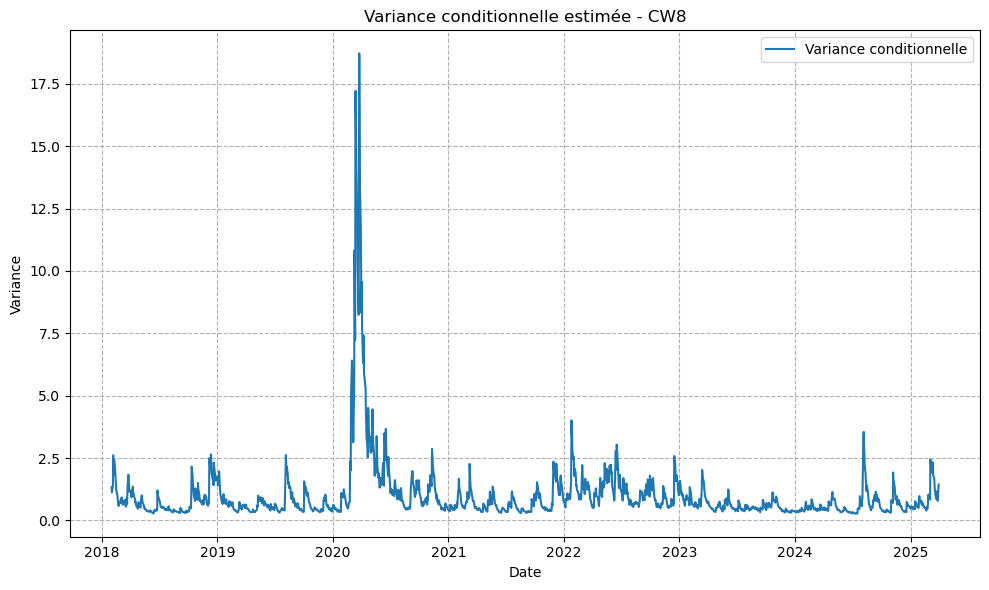

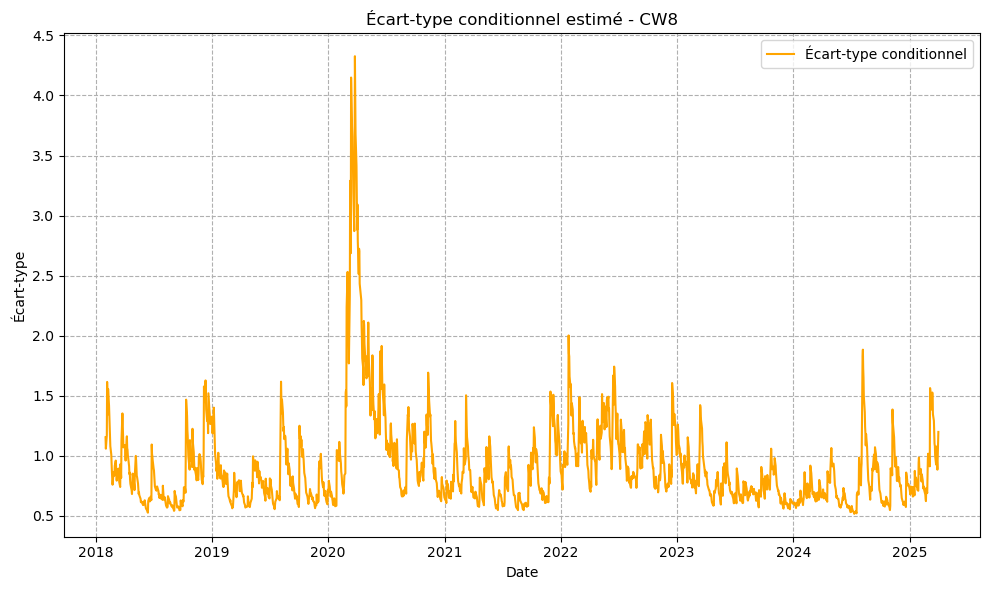


Estimation du modèle GARCH(1,1) pour CI2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3163875948104.7144
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1048723521.1335834
Iteration:      3,   Func. Count:     21,   Neg. LLF: 870649976.7063007
Iteration:      4,   Func. Count:     27,   Neg. LLF: 3169.6017867040778
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2839.5952144051134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 5872.648653940078
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2801.8870915912516
Iteration:      8,   Func. Count:     52,   Neg. LLF: 2789.9640203500553
Iteration:      9,   Func. Count:     57,   Neg. LLF: 2789.943536796077
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2789.943221696528
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2789.943206035994
Iteration:     12,   Func. Count:     72,   Neg. LLF: 2789.9432053090645
Optimization terminated successfully    (Exit mode 0)
            Current function valu

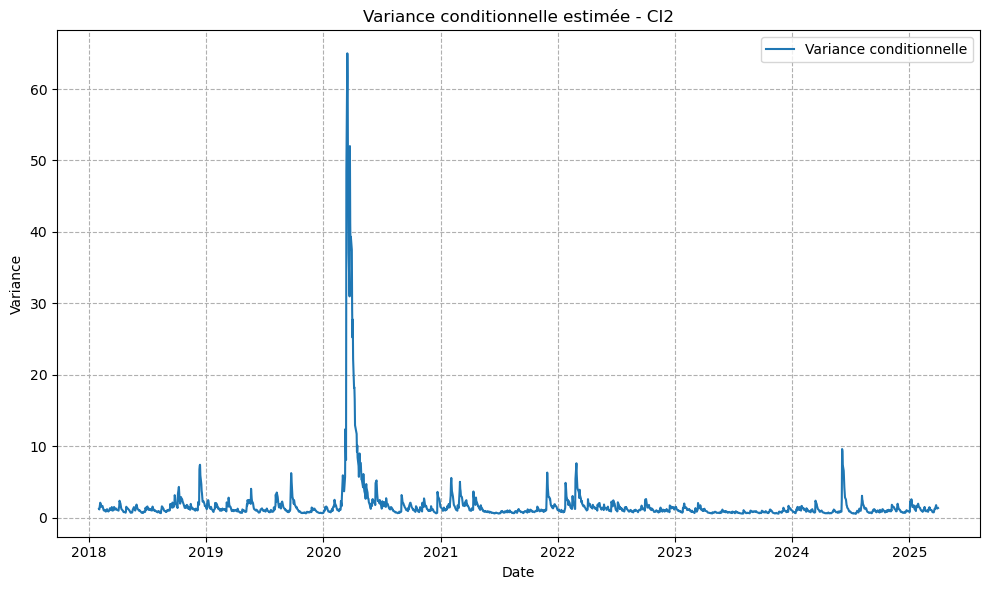

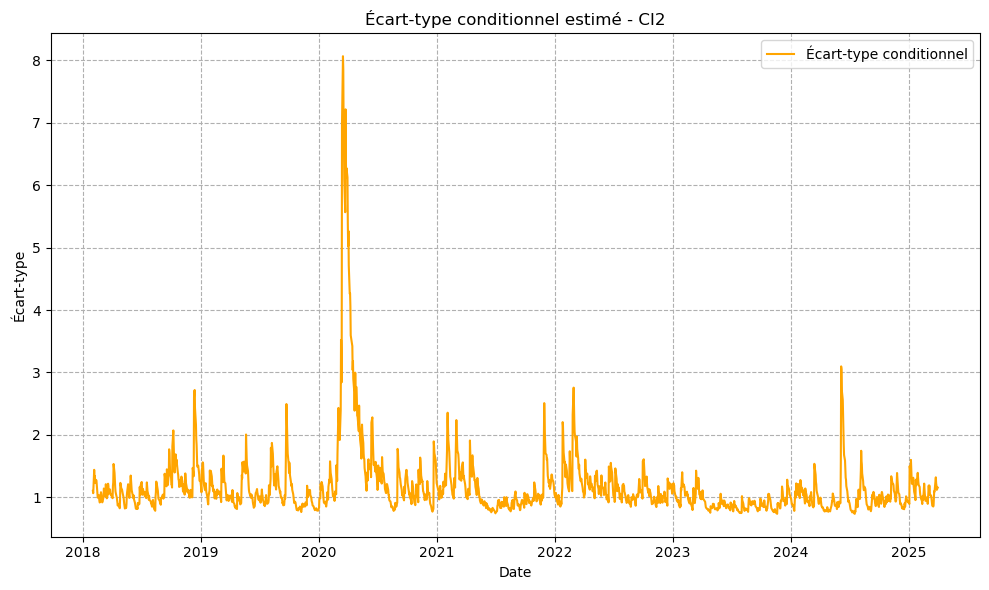


Estimation du modèle GARCH(1,1) pour EPRE
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4557322.951348495
Iteration:      2,   Func. Count:     15,   Neg. LLF: 6539.904391165829
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2854.3947080074677
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2996.960103748399
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2854.4931508770596
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2844.446431471809
Iteration:      7,   Func. Count:     46,   Neg. LLF: 2859.212744742344
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3331.66808244568
Iteration:      9,   Func. Count:     60,   Neg. LLF: 2844.1593166203793
Iteration:     10,   Func. Count:     65,   Neg. LLF: 2844.1512310549497
Iteration:     11,   Func. Count:     70,   Neg. LLF: 2844.151166252161
Iteration:     12,   Func. Count:     74,   Neg. LLF: 2844.1511662531716
Optimization terminated successfully    (Exit mode 0)
            Current function value:

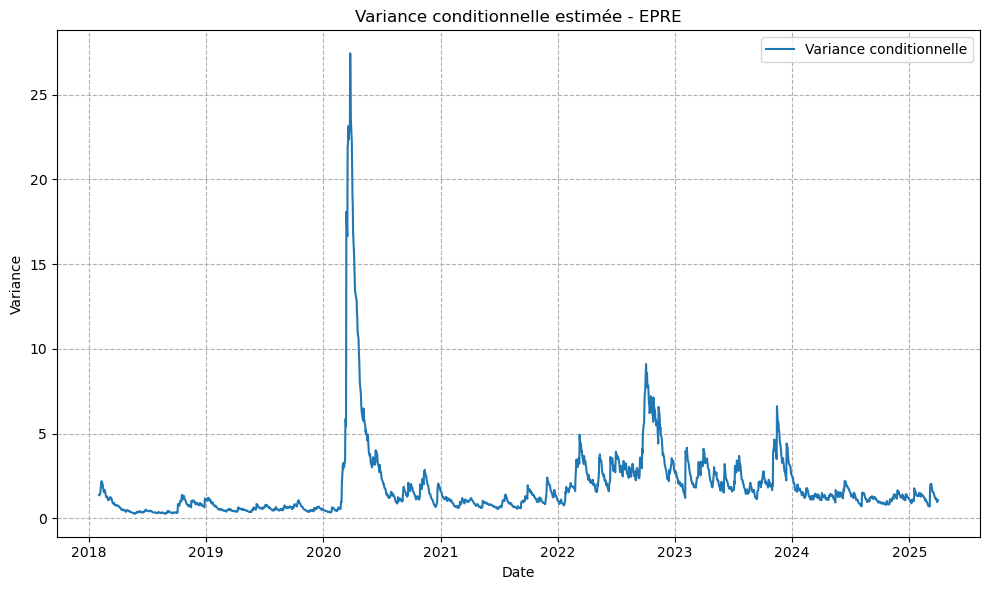

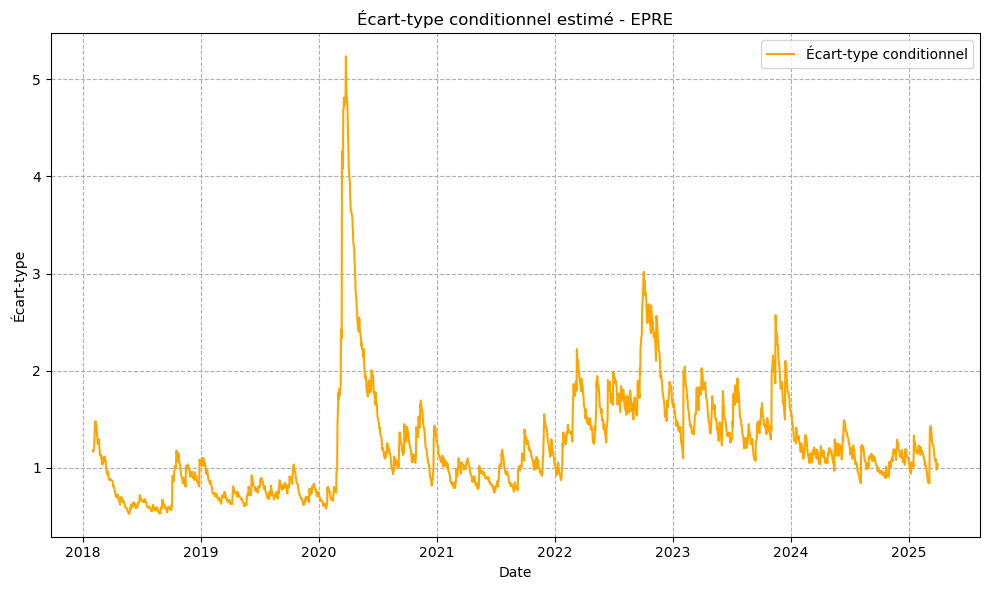

In [347]:
# GARCH(1,1)
# Liste des ETF à analyser
etfs = ['CW8', 'CI2', 'EPRE']

# Dictionnaire pour stocker les résultats de chaque estimation
garch_results = {}

# Estimation du modèle GARCH(1,1) pour chaque ETF
for etf in etfs:
    print(f"\nEstimation du modèle GARCH(1,1) pour {etf}")
    series = log_ret[etf]   # rendements en %
    model = arch_model(series, vol='Garch', p=1, q=1, mean='Constant', dist='normal')
    res = model.fit()
    garch_results[etf] = res  # Enregistrement du résultat dans le dictionnaire
    result = res.summary()
    print(result)
    
    # Tracer la variance conditionnelle
    plt.figure(figsize=(10, 6))
    plt.plot(res.conditional_volatility**2, label='Variance conditionnelle')
    plt.title(f'Variance conditionnelle estimée - {etf}')
    plt.xlabel('Date')
    plt.ylabel('Variance')
    plt.grid(True, linestyle = '--')
    plt.legend()
    plt.tight_layout()
    # sauver le graphique
    #plt.savefig(
     #   f'variance_cond_{etf}.png',
      #  format='png',
      #  dpi=300,
      #  bbox_inches='tight'
    #)
    plt.show()
    
    # Tracer l'écart-type conditionnel
    plt.figure(figsize=(10, 6))
    plt.plot(res.conditional_volatility, label='Écart-type conditionnel', color='orange')
    plt.title(f'Écart-type conditionnel estimé - {etf}')
    plt.xlabel('Date')
    plt.ylabel('Écart-type')
    plt.grid(True, linestyle = '--')
    plt.legend()
    plt.tight_layout()
    # sauver le graphique
    #plt.savefig(
       # f'ecart_type_cond_{etf}.png',
       # format='png',
       # dpi=300,
        #bbox_inches='tight'
    #)
    plt.show()
       

## Validation des modèles

In [387]:
garch_results['CW8']

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    CW8   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2322.18
Distribution:                  Normal   AIC:                           4652.36
Method:            Maximum Likelihood   BIC:                           4674.42
                                        No. Observations:                 1835
Date:                Mon, May 12 2025   Df Residuals:                     1834
Time:                        05:19:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0815  1.801e-02      4.526  6.018e-06 [4.622e-0

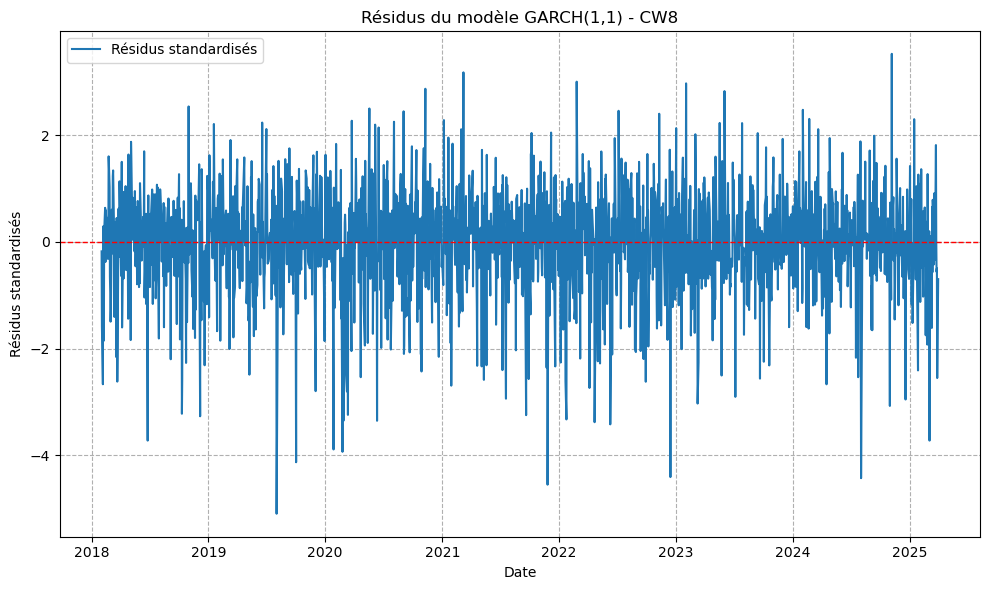


Résultats pour CW8
--------------------------------------------------
Skewness : -0.628
Kurtosis : 4.869
Statistique de Jarque-Bera : 387.947
p-value : 0.000
On rejette l'hypothèse de normalité au seuil de 5%.


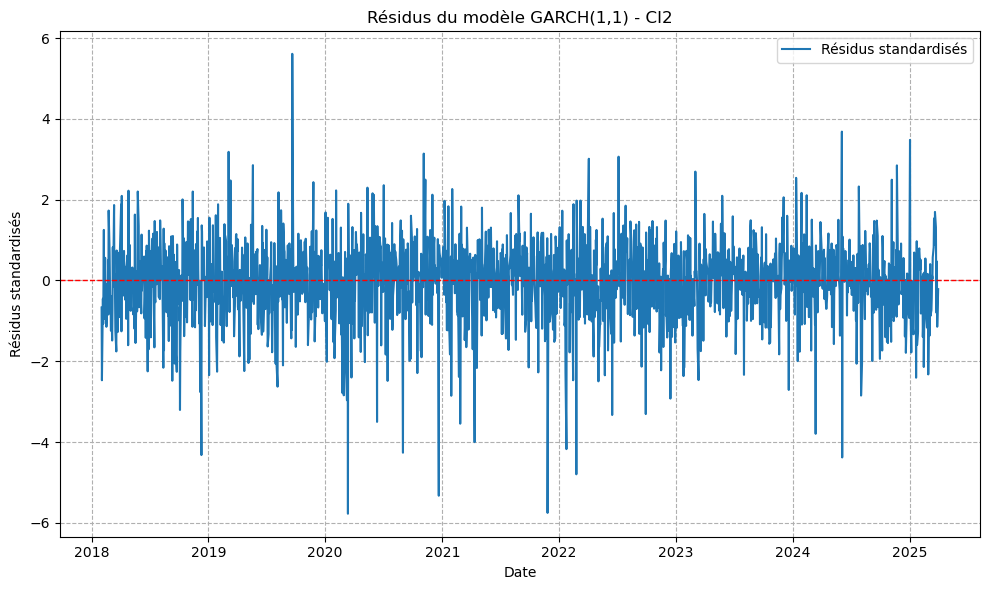


Résultats pour CI2
--------------------------------------------------
Skewness : -0.590
Kurtosis : 6.337
Statistique de Jarque-Bera : 957.904
p-value : 0.000
On rejette l'hypothèse de normalité au seuil de 5%.


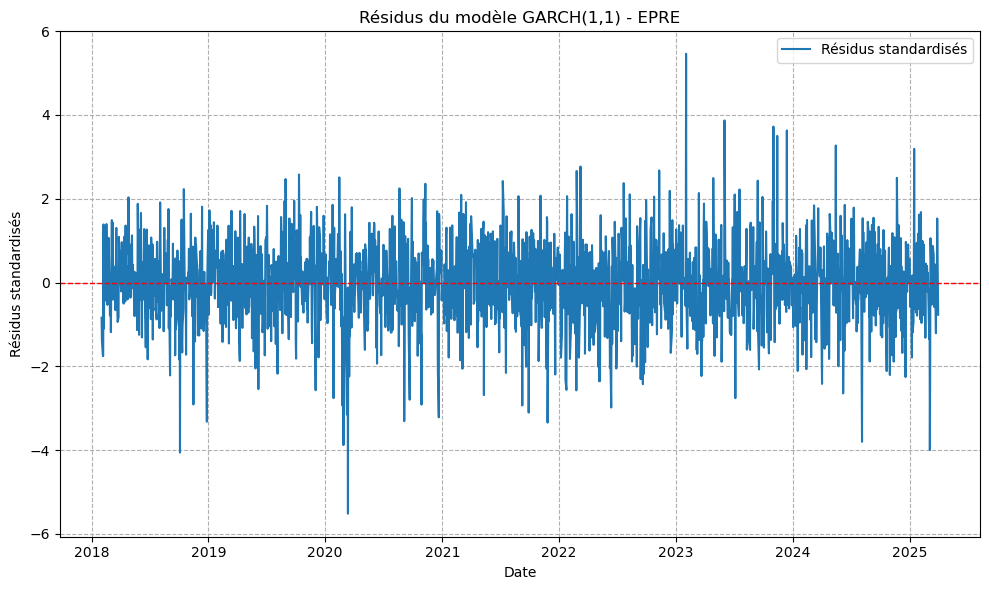


Résultats pour EPRE
--------------------------------------------------
Skewness : -0.154
Kurtosis : 4.731
Statistique de Jarque-Bera : 236.315
p-value : 0.000
On rejette l'hypothèse de normalité au seuil de 5%.


In [382]:
# Test de Jarque-Bera pour les résidus standarisés issus du modèle GARCH(1,1)
# Liste des ETF à analyser
etfs = ['CW8', 'CI2', 'EPRE']

for etf in etfs:
    res = garch_results[etf]
    resid = res.resid
    cond_vol = res.conditional_volatility
    resid_std = resid / cond_vol

    plt.figure(figsize=(10, 6))
    plt.plot(resid_std, label='Résidus standardisés')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Résidus du modèle GARCH(1,1) - {etf}')
    plt.xlabel('Date')
    plt.ylabel('Résidus standardisés')
    plt.legend()
    plt.grid(True, linestyle = '--')
    plt.tight_layout()
    # sauver le graphique
    #plt.savefig(
      #  f'resid_garch_cond_{etf}.png',
      #  format='png',
      #  dpi=300,
       # bbox_inches='tight'
   # )
    plt.show()
    
    # Calcul du skewness
    sk = skew(resid_std)

    # Calcul de l'excès de kurtosis (kurtosis)
    kurt = kurtosis(resid_std, fisher=False)  

    # Test de Jarque-Bera
    jb_stat, jb_p = jarque_bera(resid_std)

    print(f"\nRésultats pour {etf}")
    print("-" * 50)
    print(f"Skewness : {sk:.3f}")
    print(f"Kurtosis : {kurt:.3f}")
    print(f"Statistique de Jarque-Bera : {jb_stat:.3f}")
    print(f"p-value : {jb_p:.3f}")

    if jb_p < 0.05:
        print("On rejette l'hypothèse de normalité au seuil de 5%.")
    else:
        print("On ne rejette pas l'hypothèse de normalité au seuil de 5%.")
        

### Le test de Ljung–Box

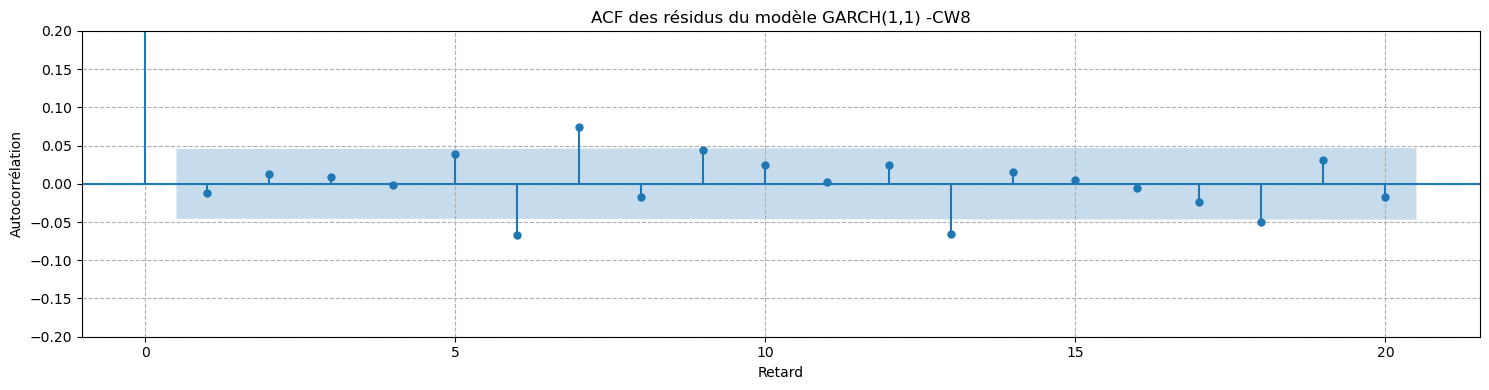

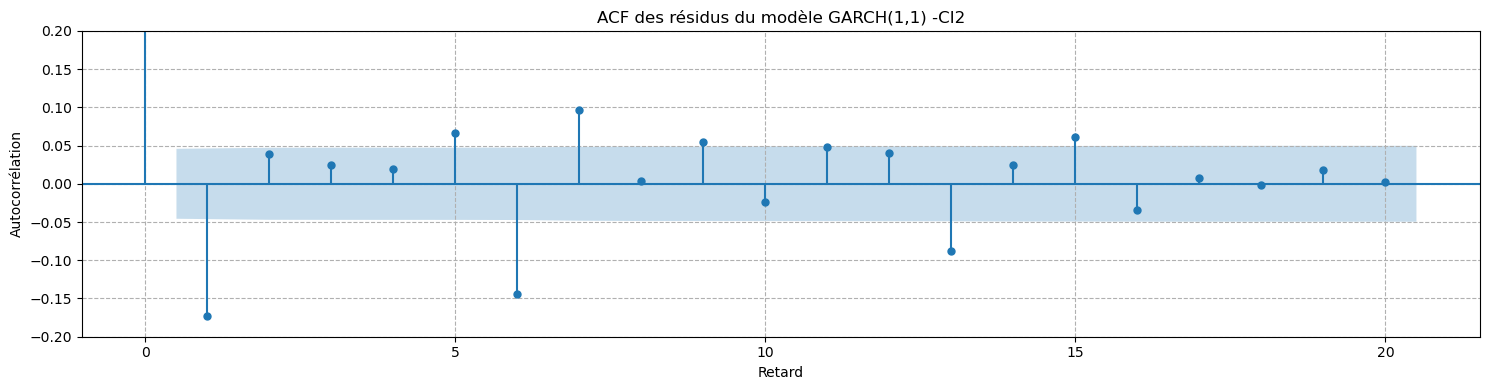

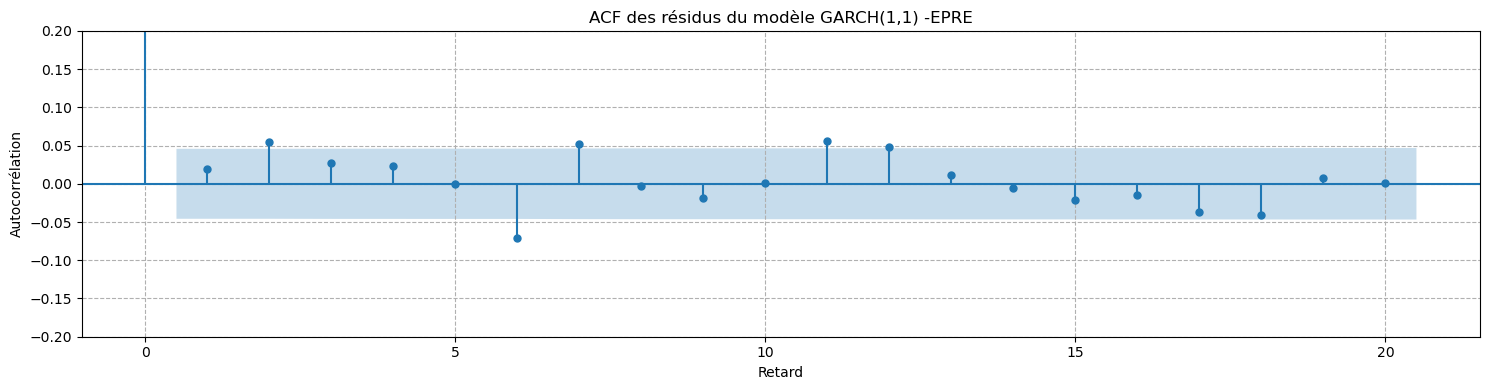

P-values pour le test de Ljung–Box :
         CW8           CI2      EPRE
1   0.623735  1.058547e-13  0.400393
2   0.766114  2.489554e-13  0.047961
3   0.881220  8.865973e-13  0.057897
4   0.955098  3.164733e-12  0.074087
5   0.632991  2.897190e-13  0.129491
6   0.066369  1.227413e-20  0.006662
7   0.002435  1.455575e-23  0.001796
8   0.003815  6.323042e-23  0.003512
9   0.001803  1.814148e-23  0.005198
10  0.002176  4.324745e-23  0.009081
11  0.003864  2.218185e-23  0.002012
12  0.004546  2.042375e-23  0.000753
13  0.000480  8.946272e-26  0.001236
14  0.000731  1.867253e-25  0.002079
15  0.001238  2.692484e-26  0.002602
16  0.002022  3.209358e-26  0.003708
17  0.002354  9.897796e-26  0.002728
18  0.000845  3.120681e-25  0.001691
19  0.000758  7.362079e-25  0.002592


In [564]:
# Liste des ETF à analyser
etfs = ['CW8', 'CI2', 'EPRE']
# Choisir les retards (lags) à tester
lags = list(range(1, 20))

# DataFrame pour stocker les p-values
p_values_df = pd.DataFrame(index=lags, columns=etfs)

for etf in etfs:
    res = garch_results[etf]
    resid = res.resid

    plt.figure(figsize=(15, 4))
    plot_acf(resid, lags=20, ax=plt.gca(), title=f'ACF des résidus du modèle GARCH(1,1) -{etf}')
    plt.xlabel("Retard")
    plt.ylabel("Autocorrélation")
    plt.ylim(-0.2, 0.2)
    plt.grid(True, linestyle = '--')
    plt.tight_layout()

    # sauver le graphique
    #plt.savefig(
      #  f'acf_garch-{etf}.png',
       # format='png',
       # dpi=300,
        #bbox_inches='tight'
    #)

    plt.show()

    # Exécuter le test de Ljung–Box
    result = acorr_ljungbox(resid, lags=lags, return_df=True)

    # Récupérer et stocker les p-values
    p_values_df[etf] = result['lb_pvalue'].values

# Création d'un tableau LaTeX pour le rapport
#lb_df_table = p_values_df.round(4).to_latex(escape=False)

# Sauvegarde du tableau LaTeX
#with open('lb_df.tex', 'w', encoding='utf-8') as f:
 #   f.write(lb_df_table)

# Afficher les p-values par ETF et par lag
print("P-values pour le test de Ljung–Box :")
print(p_values_df)

### Le test ARCH-LM

In [402]:
# Choix du nombre de lags à inclure dans le test
nlags = 20

# Liste des ETF à tester (par exemple)
etfs = ['CW8', 'CI2', 'EPRE']

# DataFrame pour stocker les résultats
arch_results = pd.DataFrame(
    index=etfs,
    columns=['LM_stat', 'LM_pvalue', 'F_stat', 'F_pvalue']
)

for etf in etfs:
    # Récupérer les résidus du modèle GARCH ou autre
    resid = garch_results[etf].resid

    # Appliquer le test ARCH-LM
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(resid, nlags=nlags)

    # Stocker les résultats
    arch_results.loc[etf] = [lm_stat, lm_pvalue, f_stat, f_pvalue]

print("Résultats du test ARCH-LM :")
print(arch_results)

Résultats du test ARCH-LM :
         LM_stat LM_pvalue     F_stat F_pvalue
CW8   498.949267       0.0  34.007617      0.0
CI2   726.674231       0.0  59.892617      0.0
EPRE  438.575823       0.0  28.581488      0.0


In [405]:
het_arch(resid, nlags=nlags)

(438.57582284801543,
 1.9586289765048974e-80,
 28.581488150598677,
 5.596169239457388e-93)

## Exercice 4

### Modèle GARCH Multivariés (BEKK (1,1))

Cette partie est fait avec R avec les rendements enrégistrés dans la première partie de l'exercice 2, car il n'y a pas de package spécifique en Python pour estimer ce modèle.

## Exercice 5

### Sélection de l'ordre du modèle VAR

In [421]:
log_ret.head() # rendements

,CW8,CI2,EPRE
Date,,,
2018-02-01,-0.121123,-0.677122,-0.950491
2018-02-02,-1.598610,-2.575271,-1.583798
2018-02-05,-3.040887,-0.588821,-2.081975
2018-02-06,0.386602,-1.367725,-2.265706
2018-02-07,0.521300,0.227941,1.996067


In [452]:
# Créer le modèle VAR
model = VAR(log_ret)

order_selection = model.select_order(maxlags=15)
results_df = order_selection.summary()

results_df


C:\Users\sodji\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.3309,0.3399,1.392,0.3342
1,0.2943,0.3306*,1.342,0.3077*
2,0.2922,0.3557,1.339,0.3156
3,0.2932,0.3839,1.341,0.3267
4,0.2881,0.4061,1.334,0.3316
5,0.2794,0.4246,1.322,0.3330
6,0.2680,0.4404,1.307,0.3316
7,0.2605*,0.4602,1.298*,0.3342
8,0.2661,0.4930,1.305,0.3498
9,0.2654,0.5195,1.304,0.3592


### Modèle VAR pour les rendements des 3 ETF.

In [462]:
# Estimer le modèle VAR(7)
model = VAR(log_ret)
results = model.fit(7)
# Afficher les statistiques du modèle
print("\nRésumé du modèle VAR(7) :")
print(results.summary())


Résumé du modèle VAR(7) :
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, May, 2025
Time:                     04:21:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.451292
Nobs:                     1828.00    HQIC:                  0.325709
Log likelihood:          -7946.08    FPE:                    1.28701
AIC:                     0.252317    Det(Omega_mle):         1.24164
--------------------------------------------------------------------
Results for equation CW8
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.045012         0.022885            1.967           0.049
L1.CW8          0.102323         0.032310            3.167           0.002
L1.CI2         -0.116775         0.021328           -5.475 

C:\Users\sodji\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Test de causalité au sens de Granger

In [503]:
# Estimer le modèle VAR(7)
model = VAR(log_ret)
results = model.fit(7)

variables = log_ret.columns.tolist()
n_lags = 7

for dep in variables:
    print(f"\n--- Équation pour {dep} ---")
    for exog in variables:
        
        # Test de causalité de Granger (tous les lags de exog dans l'équation dep)
        causality = results.test_causality(causing=exog, caused=dep, kind='f')
        print(f"Test F pour l'absence d'effet de {exog} (tous les lags) :")
        print(f"  Stat F = {causality.test_statistic:.4f}, p-value = {causality.pvalue:.4e}")


for dep in variables:
    # Liste des autres variables (toutes sauf la dépendante)
    others = [v for v in variables if v != dep]
    # Test de causalité jointe (tous les lags de toutes les autres variables)
    causality = results.test_causality(causing=others, caused=dep, kind='f')
    print(f"\nTest F pour l'absence d'effet de tous les lags de {others} dans l'équation de {dep} :")
    print(f"  Stat F = {causality.test_statistic:.4f}, p-value = {causality.pvalue:.4e}")


--- Équation pour CW8 ---
Test F pour l'absence d'effet de CW8 (tous les lags) :
  Stat F = 3.4559, p-value = 1.0728e-03
Test F pour l'absence d'effet de CI2 (tous les lags) :
  Stat F = 7.7398, p-value = 2.4230e-09
Test F pour l'absence d'effet de EPRE (tous les lags) :
  Stat F = 4.6673, p-value = 3.1587e-05

--- Équation pour CI2 ---
Test F pour l'absence d'effet de CW8 (tous les lags) :
  Stat F = 3.8235, p-value = 3.7567e-04
Test F pour l'absence d'effet de CI2 (tous les lags) :
  Stat F = 11.7417, p-value = 6.4578e-15
Test F pour l'absence d'effet de EPRE (tous les lags) :
  Stat F = 6.7417, p-value = 5.5583e-08

--- Équation pour EPRE ---
Test F pour l'absence d'effet de CW8 (tous les lags) :
  Stat F = 4.4942, p-value = 5.2835e-05
Test F pour l'absence d'effet de CI2 (tous les lags) :
  Stat F = 4.8739, p-value = 1.7032e-05
Test F pour l'absence d'effet de EPRE (tous les lags) :
  Stat F = 2.0876, p-value = 4.1479e-02

Test F pour l'absence d'effet de tous les lags de ['CI2', 

C:\Users\sodji\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


###  Les graphiques des fonctions de réponse aux impulsions

C:\Users\sodji\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


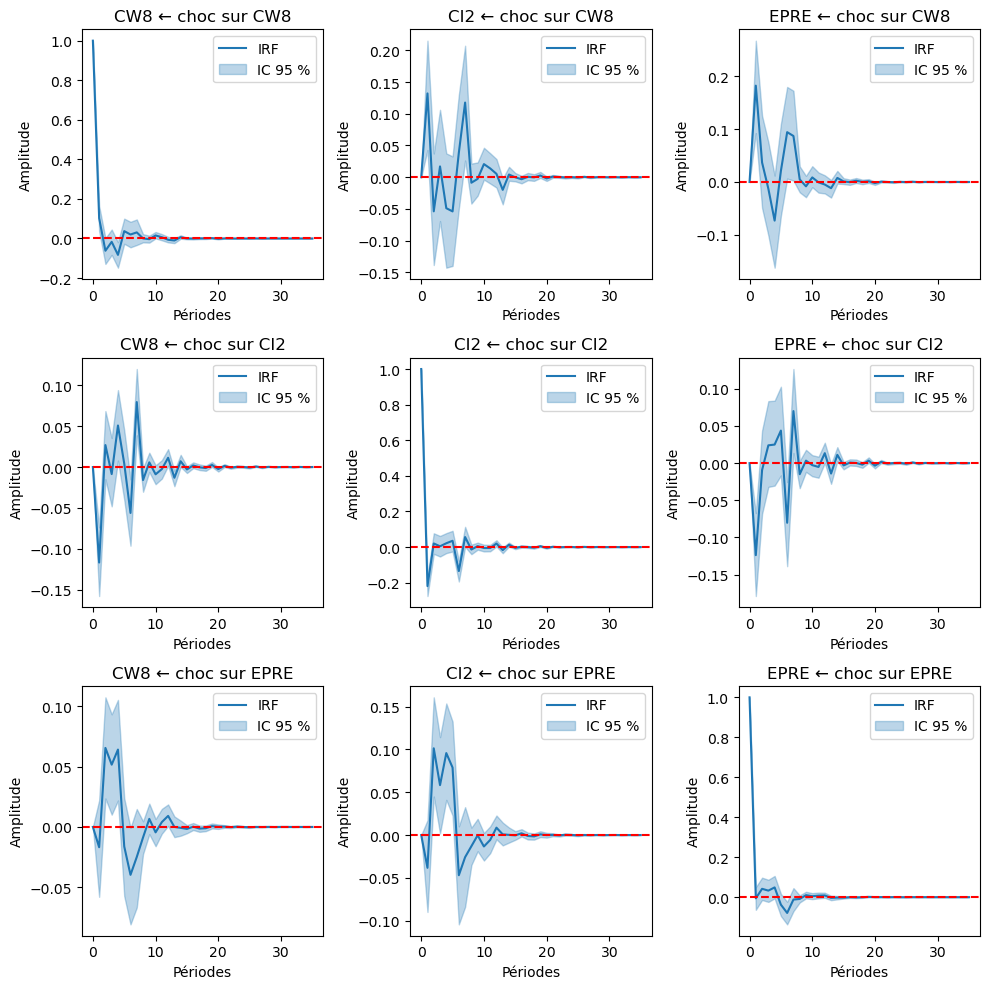

In [481]:
# Estimation du VAR(7)
model   = VAR(log_ret)
results = model.fit(7)

# Calcul des IRF 35 pas
periods = 35
irf     = results.irf(periods)         # IRAnalysis
irf_data = irf.irfs

# Bootstrap pour IC 95 % (orthodoxe ou non)
lower, upper = irf.errband_mc(
    repl=1999,
    orth=False,
    signif=0.05
)

# Tracé
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
etf_names = ['CW8', 'CI2', 'EPRE']
t = range(periods + 1)

for i, shock in enumerate(etf_names):
    for j, response in enumerate(etf_names):
        s, r = etf_names.index(shock), etf_names.index(response)

        axes[i,j].plot(t, irf_data[:, r, s], color='C0', label='IRF')
        axes[i,j].fill_between(
            t,
            lower[:, r, s],
            upper[:, r, s],
            color='C0',
            alpha=0.3,
            label='IC 95 %'
        )
        axes[i,j].axhline(0, color='r', linestyle='--')
        axes[i,j].set_title(f'{response} ← choc sur {shock}')
        axes[i,j].set_xlabel('Périodes')
        axes[i,j].set_ylabel('Amplitude')
        axes[i,j].legend()

plt.tight_layout()
    # sauver le graphique
#plt.savefig(
#    'impulsion_var.png',
#    format='png',
 #   dpi=300,
#    bbox_inches='tight'
#)
plt.show()